# Predicting real-estate prices with deep learning
- Andrew J. Graves
- 03/22/21
- Run on Google Colab with GPUs

# Load Packages

In [1]:
# Import modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, DenseFeatures, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.regularizers import l1, l2

## Exploratory Data Analysis

In [2]:
# Specify column names
cols = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 
        'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']

# Read in the data
df = pd.read_csv('data/housing.csv', sep='\s+', 
                 names=cols)

# Get the number of rows
n = len(df)

# Write data out
df.to_csv('housing_tf.csv', index=False)

First we computed several summary statistics for each feature:

In [3]:
# Get summary stats
display(df.describe())

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677082,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


Now we would like to better understand the univariate relationship with the features and the target. We will start by generating a simple correlation matrix for visualization:

In [4]:
# Display correlation matrix
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


We can see from this correlation matrix that many of the features in this data set will be useful for predicting *MEDV*. One feature we may consider dropping is *CHAS*, given that it has a low univariate correlation value with *MEDV*.

We want to better understand the functional form between the features and the target by using scatterplots, to assess for potential non-linearities:

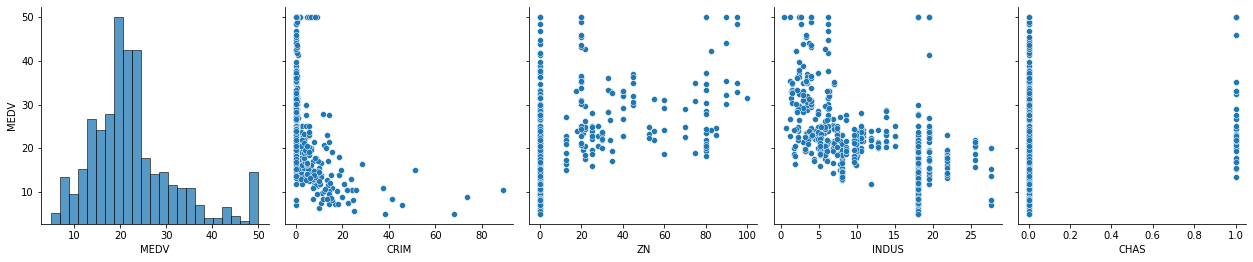

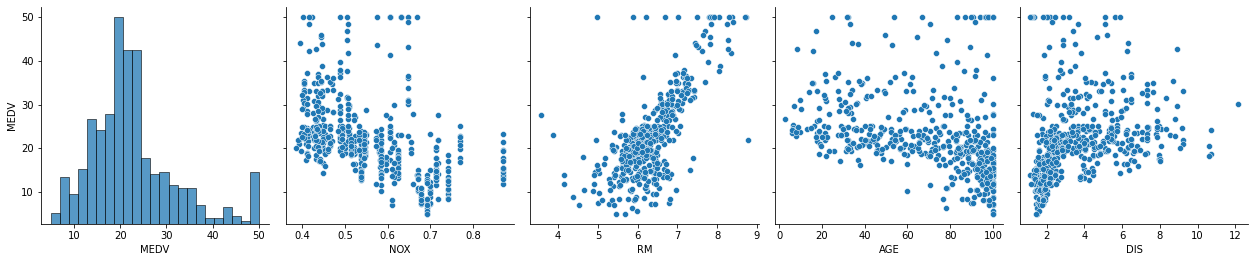

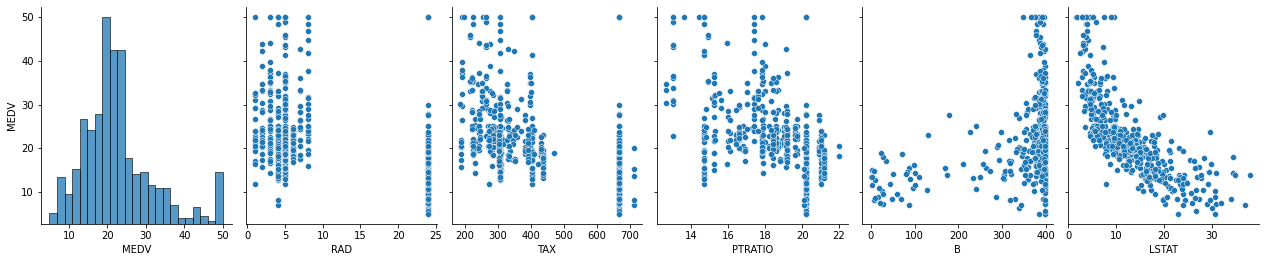

In [5]:
# Break up the predictors into 3 groups
xvars_set = [['MEDV','CRIM', 'ZN', 'INDUS', 'CHAS'], 
             ['MEDV','NOX', 'RM', 'AGE', 'DIS'], 
             ['MEDV','RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
            ]
         
for xvars in xvars_set:
    # Make pairwise plots for each predictor against the response
    pairplot = sns.pairplot(data=df,
                  y_vars=['MEDV'],
                  x_vars=xvars)
    pairplot.fig.set_size_inches(18,4)

We can see from these plots that *LSTAT*, *CRIM*, and *DIS* seem to have a non-linear relationship with *MEDV*. Although deep learning frameworks can handle non-linearities without explicit feature engineering, we are going to train our model with these specific features on a logarithmic scale. This will help linearize the relationship between these features and the target.

## Reading, splitting, and setting up pre-processing using TensorFlow

In [6]:
# Set size of training data
train_size = int(0.9*n)

# Set batch size for training data
train_batch_size = (n-train_size)*5

# Remove CHAS from the selected columns
cols.remove('CHAS')
# Read in the data using tensor flow
dataset = tf.data.experimental.make_csv_dataset('housing_tf.csv',
                                        batch_size=1,
                                        label_name='MEDV',
                                        select_columns=cols,
                                        column_defaults=[np.float()]*len(cols),
                                        shuffle=False,
                                        num_epochs=1
                                               )

# Do the train-test split
tf.random.set_seed(49)
dataset = dataset.shuffle(buffer_size=n, reshuffle_each_iteration=False)
train = dataset.take(train_size).batch(train_batch_size)
test = dataset.skip(train_size).batch(n-train_size)

# Do not preprocess the label
cols.remove('MEDV')

# Set up pre-processing layer
numerical_columns = []
for feature in cols:
    # Log and scale (z-score) these features
    if feature in ['LSTAT', 'CRIM', 'DIS']:
        num_col = tf.feature_column.numeric_column(feature,  
            normalizer_fn=lambda x: (tf.math.log(x)-tf.reduce_mean(tf.math.log(x))) / 
                                                   (tf.math.reduce_std(tf.math.log(x))+1e-32))
    else:
        # Log and scale (z-score) these features
        num_col = tf.feature_column.numeric_column(feature,
            normalizer_fn=lambda x: (x-tf.reduce_mean(x)) / 
                                                   (tf.math.reduce_std(x)+1e-32))
    # Append to column list
    numerical_columns.append(num_col)

# Build the input pre-processing layer 
PreprocessingLayer = DenseFeatures(numerical_columns, name='preproc')

## Design the model architecture and fit the model

In [7]:
# Specify parameters for each hidden layer
act_func = 'selu'
act_reg = l2(l2=1e-6)
weight_reg = l1(l1=1e-6)
weight_init = 'he_normal'
drop_rate, drop_idx = .5, 1
nodes = [64, 32, 16, 8, 4, 2]

# Apply early stopping
callback = EarlyStopping(monitor='val_loss', patience=1000, 
                         restore_best_weights=True)

# Specify the optimizer
opt = Adam(learning_rate=1e-3, beta_1=0.8, 
           beta_2=0.8, epsilon=1e-5)

# Design the deep feed-forward network architecture
model = Sequential() # instantiate the model
model.add(PreprocessingLayer) # log and normalize
# Build hidden layers
for i, node in enumerate(nodes):
    model.add(Dense(node, activation=act_func,
                    activity_regularizer=act_reg,
                    kernel_regularizer=weight_reg,
                    kernel_initializer=weight_init,
                    name=f'hidden_layer_{i+1}')
             )
    # Stop dropping out in deeper portions of the network
    if i < drop_idx:
        model.add(Dropout(drop_rate))
    # Batchnorm after activation
    model.add(BatchNormalization())
# Add the output layer
model.add(Dense(1, activation='linear', 
                name='output_layer'))

# Compile the model with MSE loss and RMSE performance metric
model.compile(loss='mse', optimizer=opt,
              metrics=[RootMeanSquaredError(name='rmse')])
# Fit the model
model.fit(train, epochs=5000, validation_data=test, 
          callbacks=[callback], verbose=0);

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


In [8]:
# Print the model design
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preproc (DenseFeatures)      multiple                  0         
_________________________________________________________________
hidden_layer_1 (Dense)       multiple                  832       
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
hidden_layer_2 (Dense)       multiple                  2080      
_________________________________________________________________
batch_normalization_1 (Batch multiple                  128       
_________________________________________________________________
hidden_layer_3 (Dense)       multiple                  5

In [9]:
# Print final RMSE
mse, rmse = model.evaluate(test)

1/1 [==============================] - 0s 62ms/step - loss: 3.4222 - rmse: 1.8496


Consider rewriting this model with the Functional API.


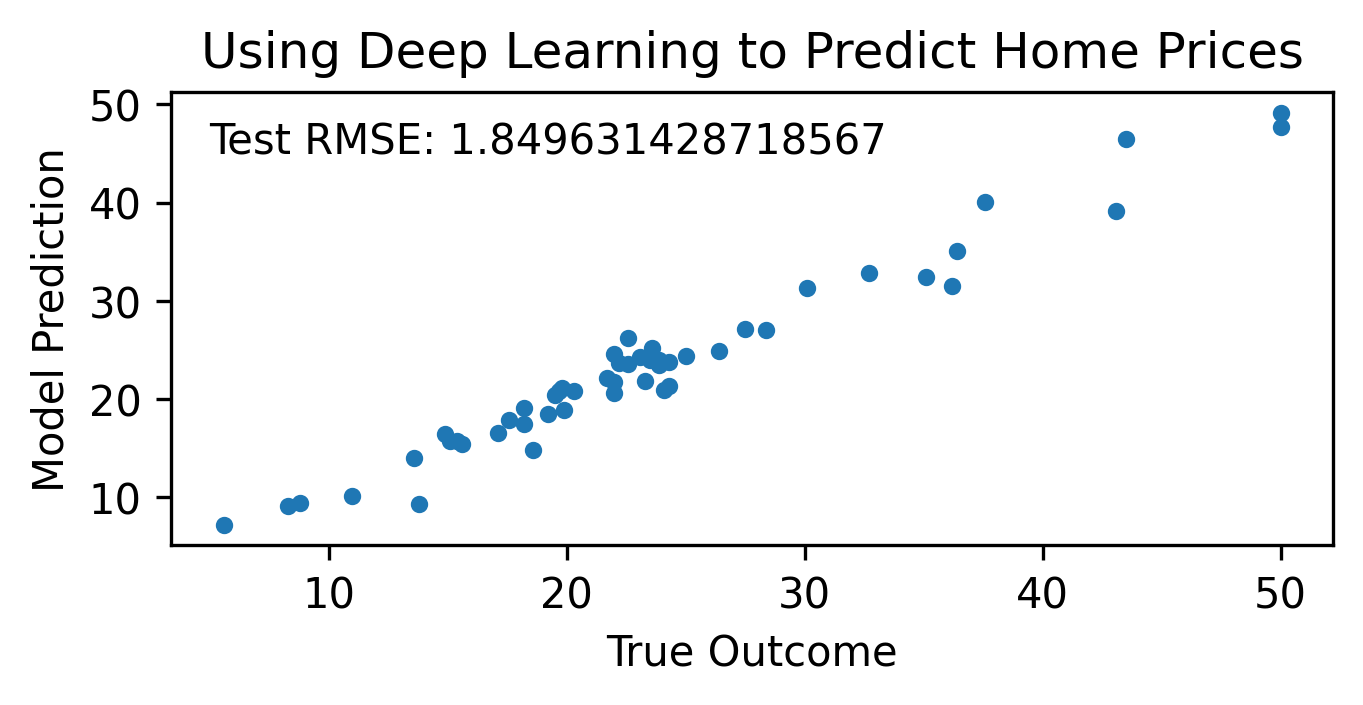

In [10]:
# Get true labels
y_true = np.array([y for _, y in test]).ravel()

# Plot the model predictions
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(5,2))
plt.scatter(y_true, model.predict(test), s=10)
plt.xlabel('True Outcome')
plt.ylabel('Model Prediction')
plt.title('Using Deep Learning to Predict Home Prices')
plt.text(x=5, y=45, s=f'Test RMSE: {rmse}')
plt.show()